- O objetivo desse código é mostrar como realizar o mascaramento de uma região e plotar o mapa.

- Para isto usaremos os shapefiles disponibilizados pelo IBGE no seu [site](https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/).

- O dado que será recortado será o arquivo netcdf de relâmpagos de Janeiro de 2022 do sensor GLM do GOES-16.

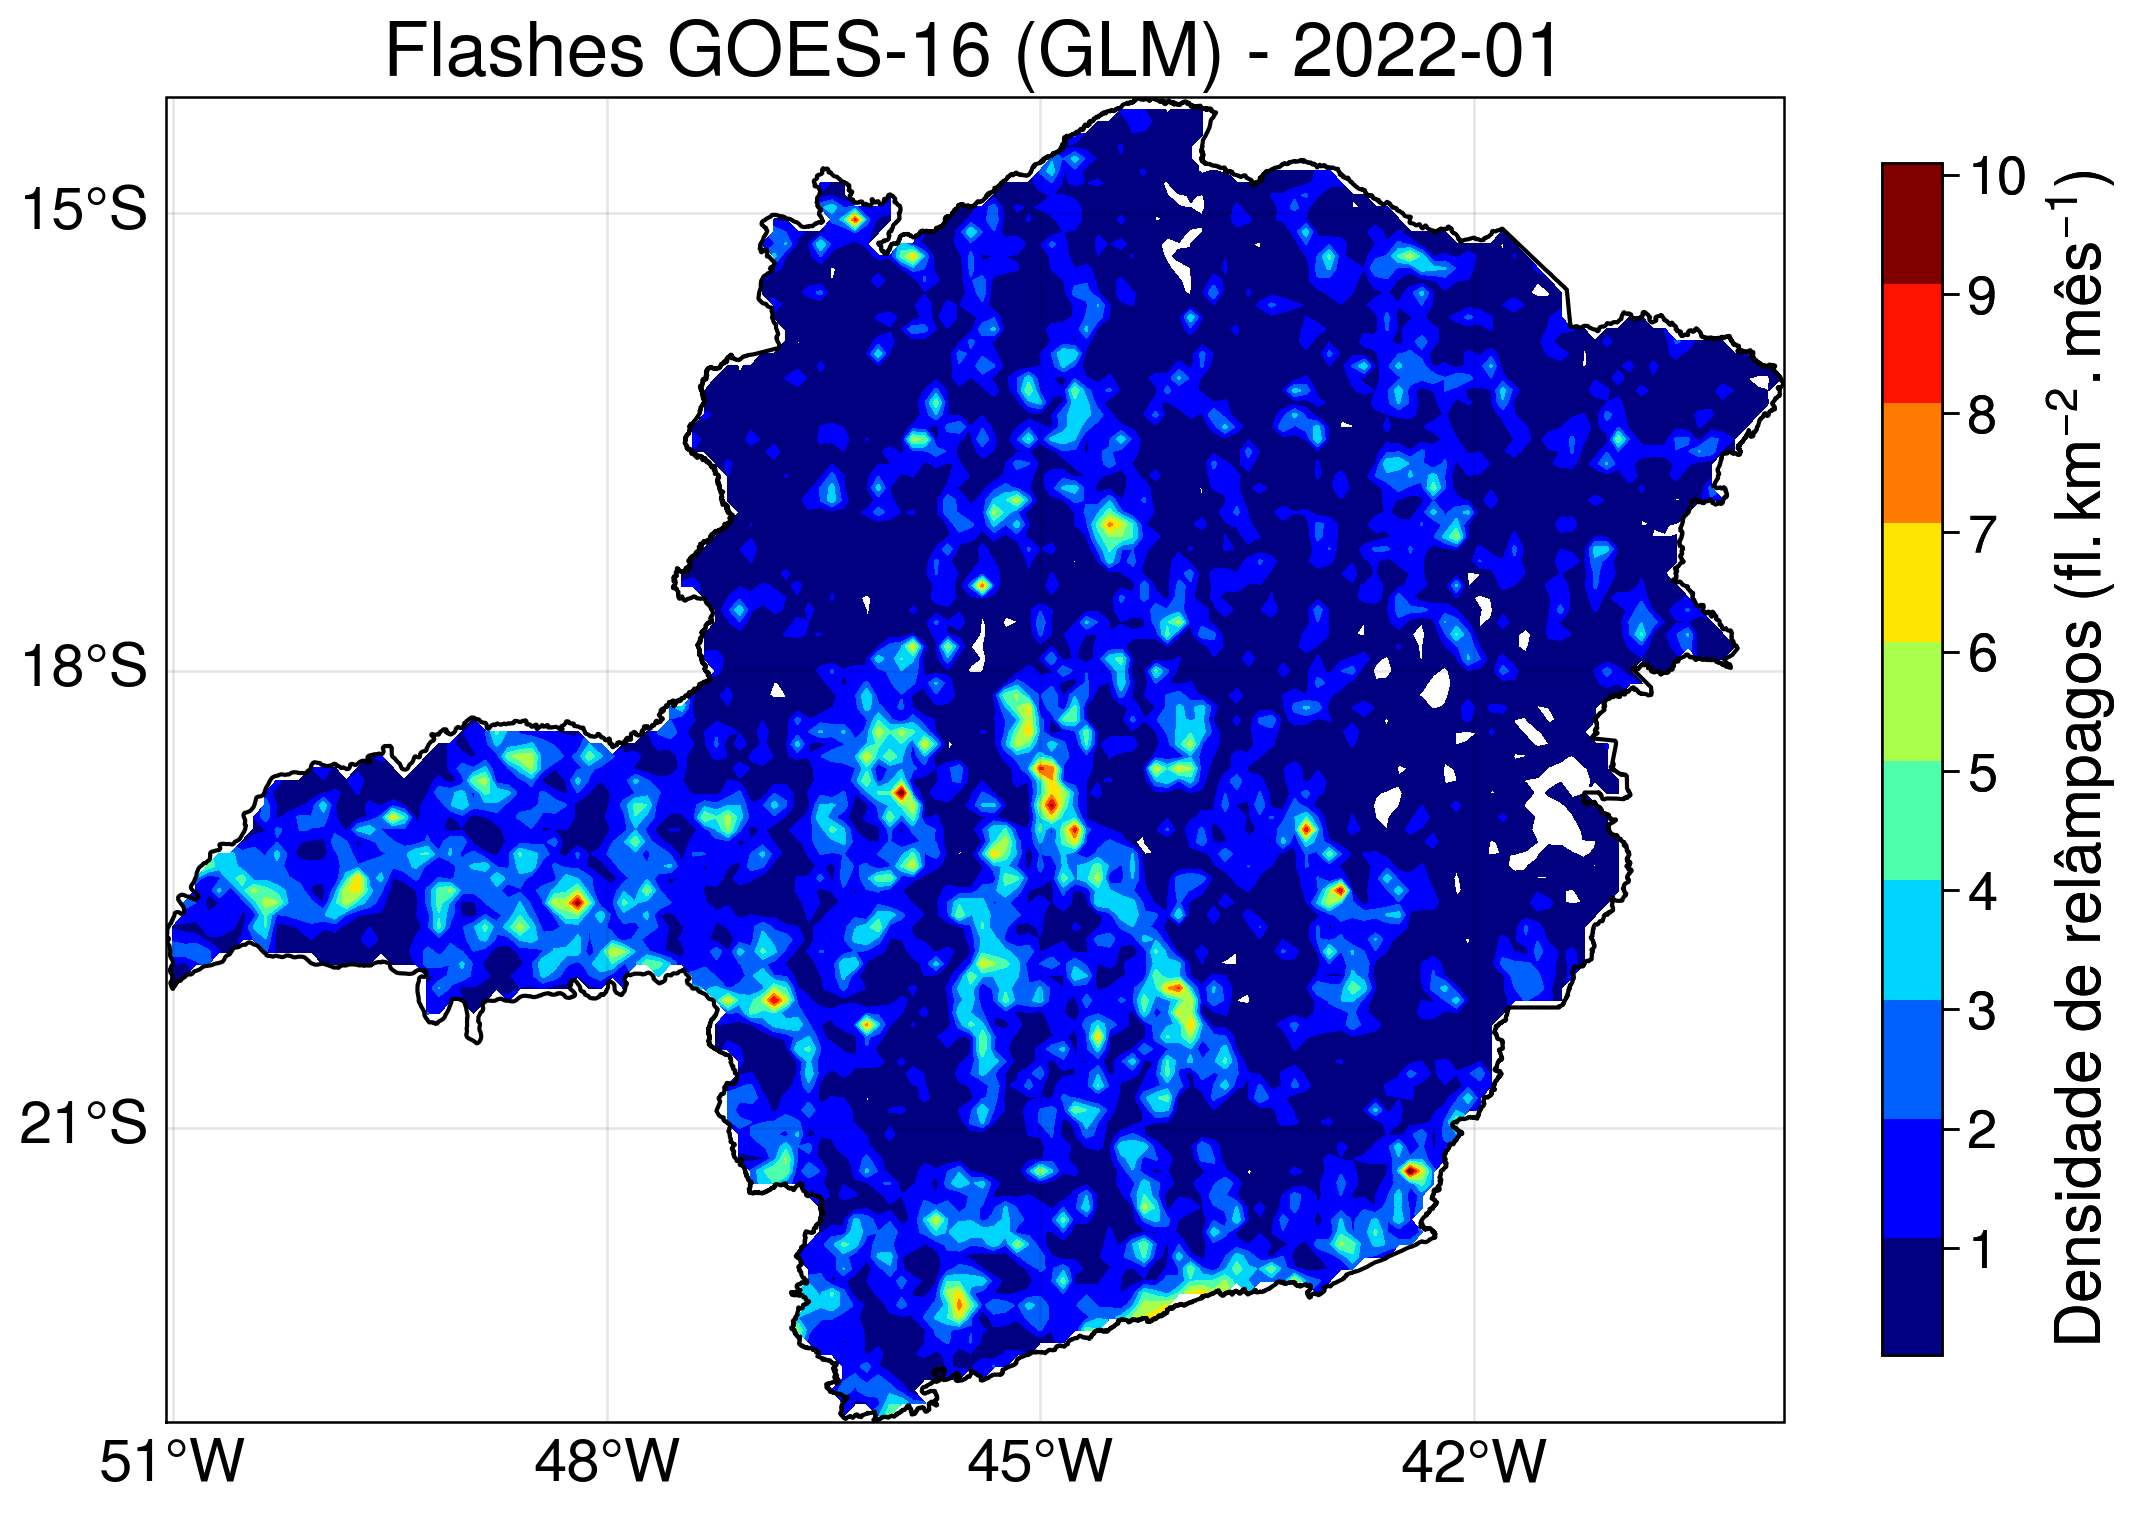

# **1° Passo:** Instalando bibliotecas

In [ ]:
# biblioteca para plotar mapas
!pip install -q proplot

!pip uninstall shapely --yes
!pip install shapely cartopy --no-binary shapely --no-binary cartopy
!wget https://raw.githubusercontent.com/SciTools/cartopy/master/tools/cartopy_feature_download.py
!python cartopy_feature_download.py physical

Chegando aqui, será necessário fazer a tediosa **Reinicialização do Ambiente de Execução** (acessar *Ambiente de execução* que esta na barra de ferramentas e clicar em *Reiniciar Ambiente de Execução* e rodar novamente a célula anterior de instalações) e ter que instalar todos os pacotes de novo. Isso é necessário para poder usar sem problemas o `Proplot` na nossa sessão do Colab, então a partir desse ponto não teremos mais que nos preocupar com a preparação do ambiente virtual.

In [ ]:
# Instalando o Salem (usado para mascarar regiões)
!pip install -q rasterio
!pip install -q pyproj
!pip install -q geopandas
!pip install -q salem

# **2° Passo:** Importando bibliotecas

In [6]:
import salem
import matplotlib.pyplot as plt
import xarray as xr
import proplot as pplt
import numpy as np
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import geopandas as gpd

import warnings
warnings.filterwarnings("ignore")

# **3° Passo:** Montando o drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Insira o caminho do drive:

In [5]:
dir = '/content/drive/MyDrive/PYHTON/00_GITHUB/00c_CODIGOS_EXTRAS_PYTHON/'

#**1) GERANDO OS MAPAS RECORTADOS usando shapefile do IBGE**

## Baixando shapefiles do IBGE

Baixaremos os shapefiles do IBGE através deste [link]( https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/):

In [132]:
# link dos dados
url = 'https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019'

# baixando shapefile dos Estados brasileiros
print('------ BAIXANDO OS SHAPEFILES DE TODOS OS ESTADOS DO BRASIL ------')
!wget -c {url}/Brasil/BR/br_unidades_da_federacao.zip
!unzip -o /content/br_unidades_da_federacao.zip
print(' ')

# baixando shapefile de um Estado em específico
print('------ BAIXANDO O SHAPEFILE DE UM ESTADO DO BRASIL ------')
!wget -c {url}/UFs/MG/mg_unidades_da_federacao.zip
!unzip -o /content/mg_unidades_da_federacao.zip
print(' ')

# baixando shapefile de todas as cidades do Brasil
print('------ BAIXANDO O SHAPEFILE DE TODOS OS MUNICIPIOS DO BRASIL ------')
!wget -c {url}/Brasil/BR/br_municipios_20200807.zip
!unzip -o /content/br_municipios_20200807.zip

------ BAIXANDO OS SHAPEFILES DE TODOS OS ESTADOS DO BRASIL ------
--2023-06-26 20:51:21--  https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/Brasil/BR/br_unidades_da_federacao.zip
Resolving geoftp.ibge.gov.br (geoftp.ibge.gov.br)... 191.233.136.86
Connecting to geoftp.ibge.gov.br (geoftp.ibge.gov.br)|191.233.136.86|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  /content/br_unidades_da_federacao.zip
 extracting: BR_UF_2019.cpg          
  inflating: BR_UF_2019.dbf          
  inflating: BR_UF_2019.prj          
  inflating: BR_UF_2019.shp          
  inflating: BR_UF_2019.shx          
 
------ BAIXANDO O SHAPEFILE DE UM ESTADO DO BRASIL ------
--2023-06-26 20:51:22--  https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/UFs/MG/mg_unidades_da_federacao.zip
Resolvin

In [133]:
# lendo shapefile de todos Estados do Brasil
estados_ibge = salem.read_shapefile('/content/BR_UF_2019.shp')
estados_ibge

,CD_UF,NM_UF,SIGLA_UF,NM_REGIAO,geometry,min_x,max_x,min_y,max_y
0,11,Rondônia,RO,Norte,"POLYGON ((-65.38150 -10.42907, -65.38013 -10.4...",-66.810253,-59.774357,-13.693700,-7.975868
1,12,Acre,AC,Norte,"POLYGON ((-71.07772 -9.82774, -71.07817 -9.828...",-73.990450,-66.623754,-11.145561,-7.111824
2,13,Amazonas,AM,Norte,"POLYGON ((-69.83766 -3.68659, -69.82555 -3.620...",-73.801558,-56.097558,-9.818046,2.246631
3,14,Roraima,RR,Norte,"POLYGON ((-63.96008 2.47313, -63.96041 2.47416...",-64.825254,-58.886884,-1.580633,5.271841
4,15,Pará,PA,Norte,"MULTIPOLYGON (((-51.43248 -0.47334, -51.42949 ...",-58.898328,-46.061425,-9.841153,2.591027
5,16,Amapá,AP,Norte,"MULTIPOLYGON (((-50.45011 2.10924, -50.44715 2...",-54.876250,-49.875682,-1.236176,4.508817
6,17,Tocantins,TO,Norte,"POLYGON ((-48.23163 -5.94614, -48.23011 -5.938...",-50.742064,-45.699265,-13.467713,-5.168381
7,21,Maranhão,MA,Nordeste,"MULTIPOLYGON (((-44.53830 -2.02124, -44.53742 ...",-48.755151,-41.795884,-10.261765,-1.049328
8,22,Piauí,PI,Nordeste,"POLYGON ((-42.91539 -6.64607, -42.91645 -6.644...",-46.028207,-40.370510,-10.928756,-2.749753
9,23,Ceará,CE,Nordeste,"POLYGON ((-41.18292 -4.01797, -41.18552 -4.017...",-41.423518,-37.252659,-7.858182,-2.784323


In [134]:
# selecionando um Estado
estado_ibge = estados_ibge.loc[ estados_ibge['SIGLA_UF'] == 'MG' ]
estado_ibge

,CD_UF,NM_UF,SIGLA_UF,NM_REGIAO,geometry,min_x,max_x,min_y,max_y
16,31,Minas Gerais,MG,Sudeste,"POLYGON ((-50.74208 -19.21384, -50.74241 -19.2...",-51.046082,-39.856829,-22.922755,-14.233181


In [135]:
# selecionando vários Estados
#estado_ibge = estados_ibge.loc[ (estados_ibge['SIGLA_UF'] == 'MG') | (estados_ibge['SIGLA_UF'] == 'SP')]
#estado_ibge

In [136]:
# lendo shapefile de MG
mg_ibge = salem.read_shapefile('/content/MG_UF_2019.shp')
mg_ibge

,CD_UF,NM_UF,SIGLA_UF,NM_REGIAO,geometry,min_x,max_x,min_y,max_y
0,31,Minas Gerais,MG,Sudeste,"POLYGON ((-50.74208 -19.21384, -50.74241 -19.2...",-51.046082,-39.856829,-22.922755,-14.233181


In [137]:
# lendo shapefile de todas as cidades do Brasil
cidades_ibge = salem.read_shapefile('/content/BR_Municipios_2019.shp')
cidades_ibge

,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2,geometry,min_x,max_x,min_y,max_y
0,1100015,Alta Floresta D'Oeste,RO,7067.025,"POLYGON ((-62.22630 -11.89037, -62.20670 -11.8...",-62.894079,-61.886511,-13.118942,-11.827457
1,1100023,Ariquemes,RO,4426.571,"POLYGON ((-63.58751 -9.84984, -63.58715 -9.849...",-63.618222,-62.422617,-10.288282,-9.669160
2,1100031,Cabixi,RO,1314.352,"POLYGON ((-60.71834 -13.39058, -60.70904 -13.3...",-60.924764,-60.365289,-13.693700,-13.318590
3,1100049,Cacoal,RO,3792.892,"POLYGON ((-61.50114 -11.30119, -61.50104 -11.2...",-61.795798,-61.000595,-11.619209,-10.987534
4,1100056,Cerejeiras,RO,2783.300,"POLYGON ((-61.51346 -13.28575, -61.51534 -13.2...",-61.908043,-60.716651,-13.363706,-13.004330
...,...,...,...,...,...,...,...,...,...
5567,5222005,Vianópolis,GO,954.284,"POLYGON ((-48.53842 -16.75003, -48.54051 -16.7...",-48.598694,-48.255546,-17.129362,-16.627415
5568,5222054,Vicentinópolis,GO,737.255,"POLYGON ((-49.90713 -17.61460, -49.90588 -17.6...",-50.087037,-49.684173,-17.899038,-17.577277
5569,5222203,Vila Boa,GO,1060.172,"POLYGON ((-47.07742 -15.06330, -47.07747 -15.0...",-47.235067,-46.873698,-15.314679,-14.671943
5570,5222302,Vila Propício,GO,2181.583,"POLYGON ((-48.91463 -15.20939, -48.91462 -15.2...",-49.092276,-48.561829,-15.570494,-14.861683


In [138]:
# seleciona uma cidade
cidade_ibge = cidades_ibge[ cidades_ibge['NM_MUN'] == 'Itajubá']
cidade_ibge

,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2,geometry,min_x,max_x,min_y,max_y
2611,3132404,Itajubá,MG,294.835,"POLYGON ((-45.51615 -22.43638, -45.51618 -22.4...",-45.530293,-45.261029,-22.539726,-22.339256


## Leitura do dado

In [139]:
ds = xr.open_dataset(f'{dir}input/flash_goes16_mensal_2022-01.nc')
ds

<xarray.Dataset>
Dimensions:  (time: 1, lat: 1664, lon: 1664)
Coordinates:
  * time     (time) datetime64[ns] 2022-01-31
  * lat      (lat) float32 -66.56 -66.48 -66.4 -66.32 ... 66.24 66.32 66.4 66.48
  * lon      (lon) float32 -141.6 -141.5 -141.4 -141.3 ... -8.68 -8.6 -8.52
Data variables:
    flash    (time, lat, lon) float32 ...

## a) Plota `Brasil`

In [140]:
# lendo shapefile do Brasil
shp = salem.read_shapefile(f'{dir}input/BRAZIL.shp')
shp

,ScaleRank,LabelRank,FeatureCla,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,GDP_MD_EST,FIPS_10_,ISO_A2,ISO_A3,ISO_N3,geometry,min_x,max_x,min_y,max_y
0,1,2,Adm-0 country,Brazil,BRA,0.0,2.0,Sovereign country,Brazil,BRA,...,1993000.0,0.0,BR,BRA,76.0,"MULTIPOLYGON (((-48.54186 -27.81670, -48.55117...",-74.018475,-28.876346,-33.74228,5.267225


In [141]:
# recorta o dado
dsr = ds.salem.roi(shape=shp)
dsr

<xarray.Dataset>
Dimensions:  (time: 1, lat: 1664, lon: 1664)
Coordinates:
  * time     (time) datetime64[ns] 2022-01-31
  * lat      (lat) float32 -66.56 -66.48 -66.4 -66.32 ... 66.24 66.32 66.4 66.48
  * lon      (lon) float32 -141.6 -141.5 -141.4 -141.3 ... -8.68 -8.6 -8.52
Data variables:
    flash    (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    pyproj_srs:  +proj=longlat +datum=WGS84 +no_defs

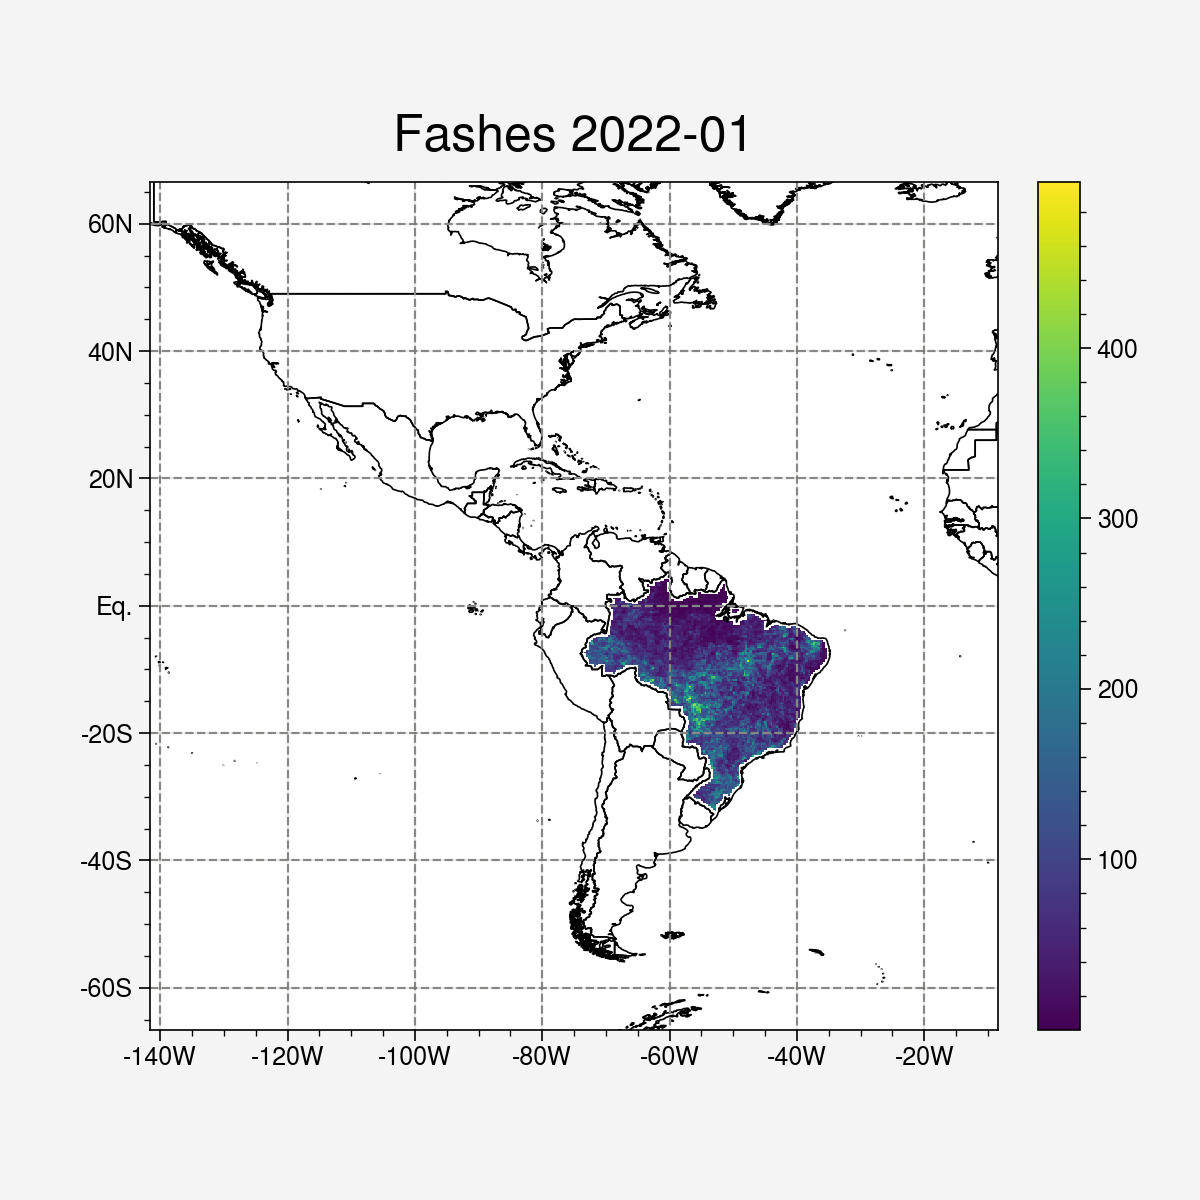

In [142]:
# parâmetros gerais da figura
fig = plt.figure(figsize=(6, 6))

# formatação dos eixos da figura
ax = fig.add_subplot(111)

# plota mapa
dsr['flash'].salem.quick_map()

# título da figura
ax.set_title('Fashes 2022-01', fontsize=18, y=1.02)

# salva figura
plt.savefig('Fig1_salem_brasil_basico.png', dpi=300, bbox_inches='tight')

## b) Plota `estado`

In [143]:
# lendo shapefile
estados_ibge = salem.read_shapefile('/content/BR_UF_2019.shp')

# selecionando o Estado de MG e SP
estado_ibge = estados_ibge.loc[estados_ibge['SIGLA_UF'] == 'MG']

# leitura do aquivo netcdf
ds = xr.open_dataset(f'{dir}input/flash_goes16_mensal_2022-01.nc')

# aplica a mascara no dado Netcdf
dsr = ds.salem.roi(shape=estado_ibge)

# tabelas dos estados selecionados
estado_ibge

,CD_UF,NM_UF,SIGLA_UF,NM_REGIAO,geometry,min_x,max_x,min_y,max_y
16,31,Minas Gerais,MG,Sudeste,"POLYGON ((-50.74208 -19.21384, -50.74241 -19.2...",-51.046082,-39.856829,-22.922755,-14.233181


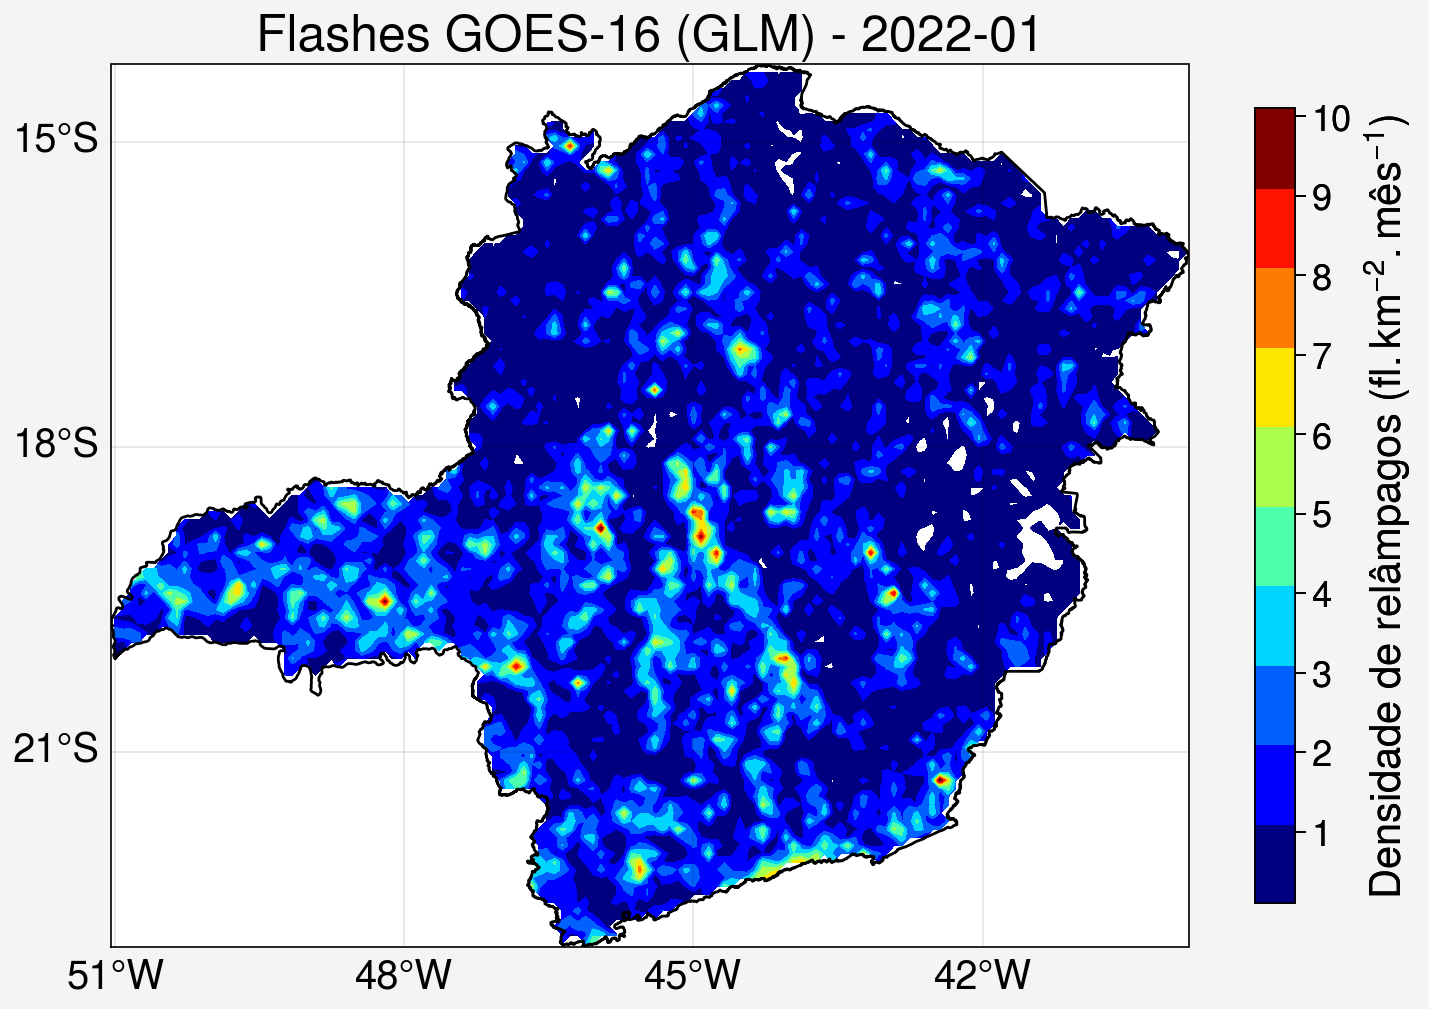

In [144]:
# limites do Estado
lonmin, lonmax, latmin, latmax = float(estado_ibge['min_x']), float(estado_ibge['max_x']), float(estado_ibge['min_y']), float(estado_ibge['max_y'])

# fazendo o recorte do dado para o Estado
dsr = dsr.sel(lat=slice(latmin, latmax), lon=slice(lonmin, lonmax))

# define a moldura da figura
fig, ax = pplt.subplots(axwidth=6, tight=True, proj='pcarree')

# define formato da figura
ax.format(coast=False, borders=False, innerborders=False,
          labels=True,
          latlines=3, lonlines=3,
          latlim=(latmin, latmax),
          lonlim=(lonmin, lonmax),
          title=f'Flashes GOES-16 (GLM) - 2022-01',
          small='20px',
          large='25px')

# plota mapa
map1 = ax.contourf(dsr['lon'],
                   dsr['lat'],
                   dsr['flash'][0,:,:]/64.,
                   cmap='jet',
                   vmin=0.1,
                   vmax=10,
                   levels=pplt.arange(0.1, 10., 1.0))

# plota contorno do Estado
estado_ibge.plot(edgecolor='black', facecolor='none', linewidth=1, alpha=1, ax=ax)

# plota barra de cores da figura
fig.colorbar(map1, loc='r',
             label='Densidade de relâmpagos $(fl.km^{-2}.mês^{-1})$',
             ticks=1, ticklabelsize=13, labelsize=15,
             space=0.2, length=0.90, width=0.2)

# salva figura
fig.save('Fig2_salem_estado.png', dpi=300)

## c) Plota `dois ou mais estados`

In [145]:
# lendo shapefile
estados_ibge = salem.read_shapefile('/content/BR_UF_2019.shp')

# selecionando o Estado de MG e SP
estado_ibge = estados_ibge.loc[ (estados_ibge['SIGLA_UF'] == 'MG') | (estados_ibge['SIGLA_UF'] == 'SP')]

# leitura do aquivo netcdf
ds = xr.open_dataset(f'{dir}input/flash_goes16_mensal_2022-01.nc')

# aplica a mascara no dado Netcdf
dsr = ds.salem.roi(shape=estado_ibge)

# tabelas dos estados selecionados
estado_ibge

,CD_UF,NM_UF,SIGLA_UF,NM_REGIAO,geometry,min_x,max_x,min_y,max_y
16,31,Minas Gerais,MG,Sudeste,"POLYGON ((-50.74208 -19.21384, -50.74241 -19.2...",-51.046082,-39.856829,-22.922755,-14.233181
19,35,São Paulo,SP,Sudeste,"MULTIPOLYGON (((-48.03716 -25.35794, -48.03750...",-53.110112,-44.161365,-25.358000,-19.779656


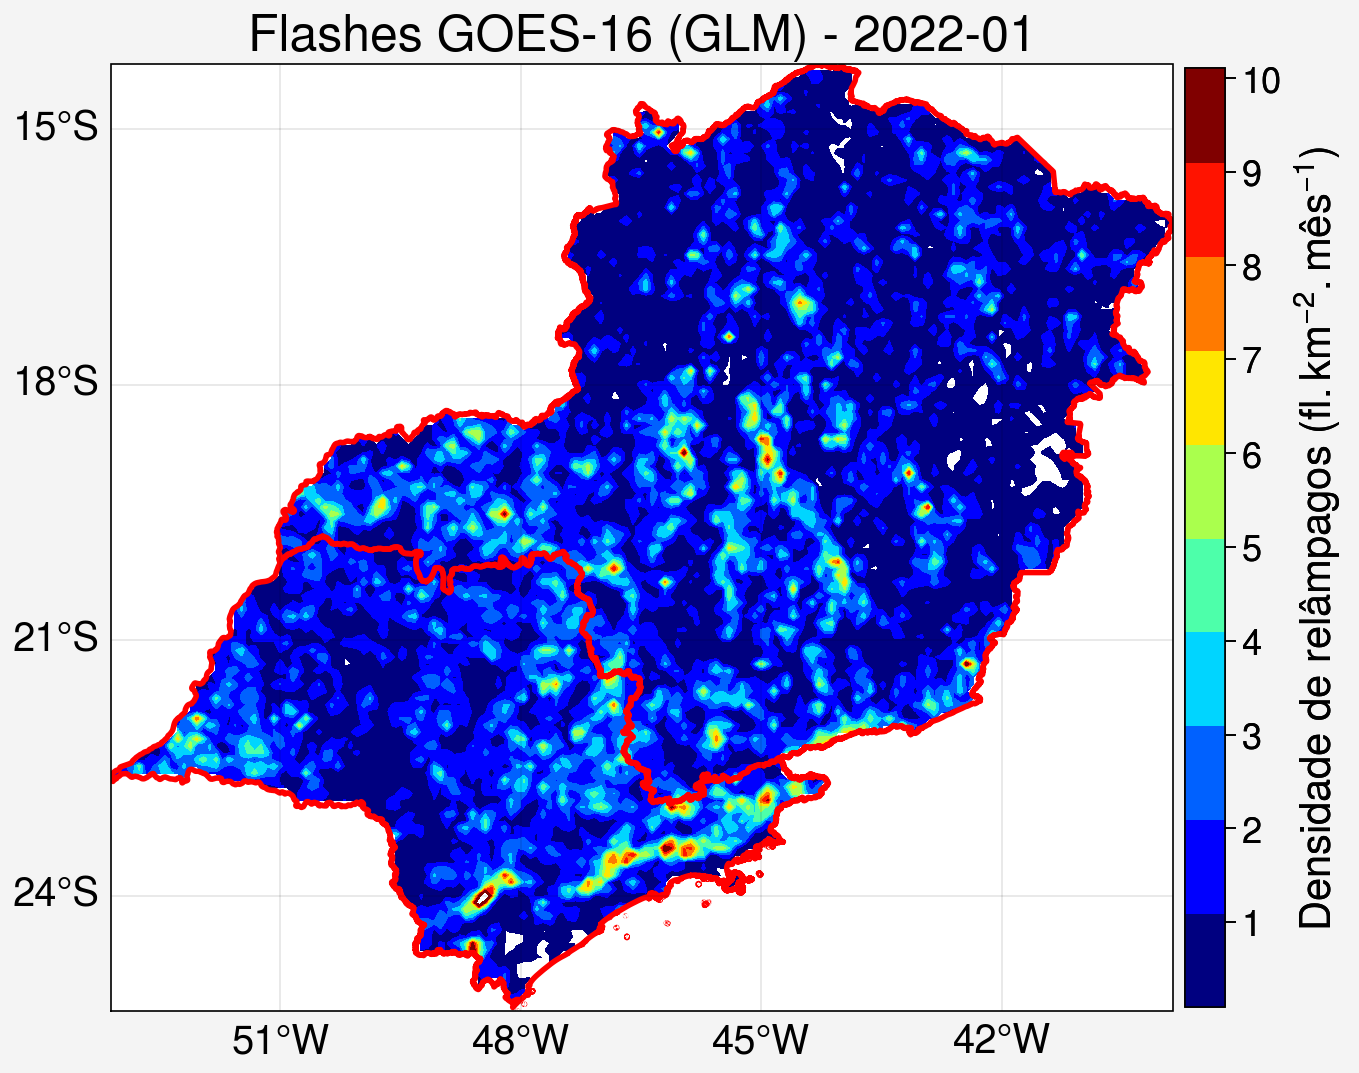

In [146]:
# limites do Estado
lonmin, lonmax = estado_ibge['min_x'].min(), estado_ibge['max_x'].max()
latmin, latmax = estado_ibge['min_y'].min(), estado_ibge['max_y'].max()

# define a moldura da figura
fig, ax = pplt.subplots(axwidth=6, tight=True, proj='pcarree')

# define formato da figura
ax.format(coast=False, borders=False, innerborders=False,
          labels=True,
          latlines=3, lonlines=3,
          latlim=(latmin, latmax),
          lonlim=(lonmin, lonmax),
          title=f'Flashes GOES-16 (GLM) - 2022-01',
          small='20px',
          large='25px')

# plota mapa
map1 = ax.contourf(dsr['lon'],
                   dsr['lat'],
                   dsr['flash'][0,:,:]/64.,
                   cmap='jet',
                   vmin=0.1, vmax=10,
                   levels=pplt.arange(0.1, 10., 1.0))

# plota contorno do Estado
estado_ibge.plot(edgecolor='red', facecolor='none', linewidth=2, alpha=1, ax=ax)

# plota barra de cores da figura
fig.colorbar(map1, loc='r', label='Densidade de relâmpagos $(fl.km^{-2}.mês^{-1})$',
             ticks=1, ticklabelsize=13, labelsize=15,
             space=-2.3, length=0.99, width=0.2)

# salva figura
fig.save('Fig3_salem_estados.png', dpi=300)

## d) Plota uma região `região`

In [147]:
# lendo shapefile
regioes_ibge = salem.read_shapefile(f'{dir}/input/regioes_2010.shp')

# selecionando a região Nordeste
regiao_ibge = regioes_ibge.loc[regioes_ibge['nome'] =='Nordeste']

# leitura do aquivo netcdf
ds = xr.open_dataset(f'{dir}input/flash_goes16_mensal_2022-01.nc')

# aplica a mascara no dado Netcdf
dsr = ds.salem.roi(shape=regiao_ibge)

# tabelas dos estados selecionados
regiao_ibge

,id,nome,sigla,geometry,min_x,max_x,min_y,max_y
3,4,Nordeste,NE,"MULTIPOLYGON (((-35.15204 -8.91295, -35.15366 ...",-48.754713,-32.390875,-18.348743,-1.045085


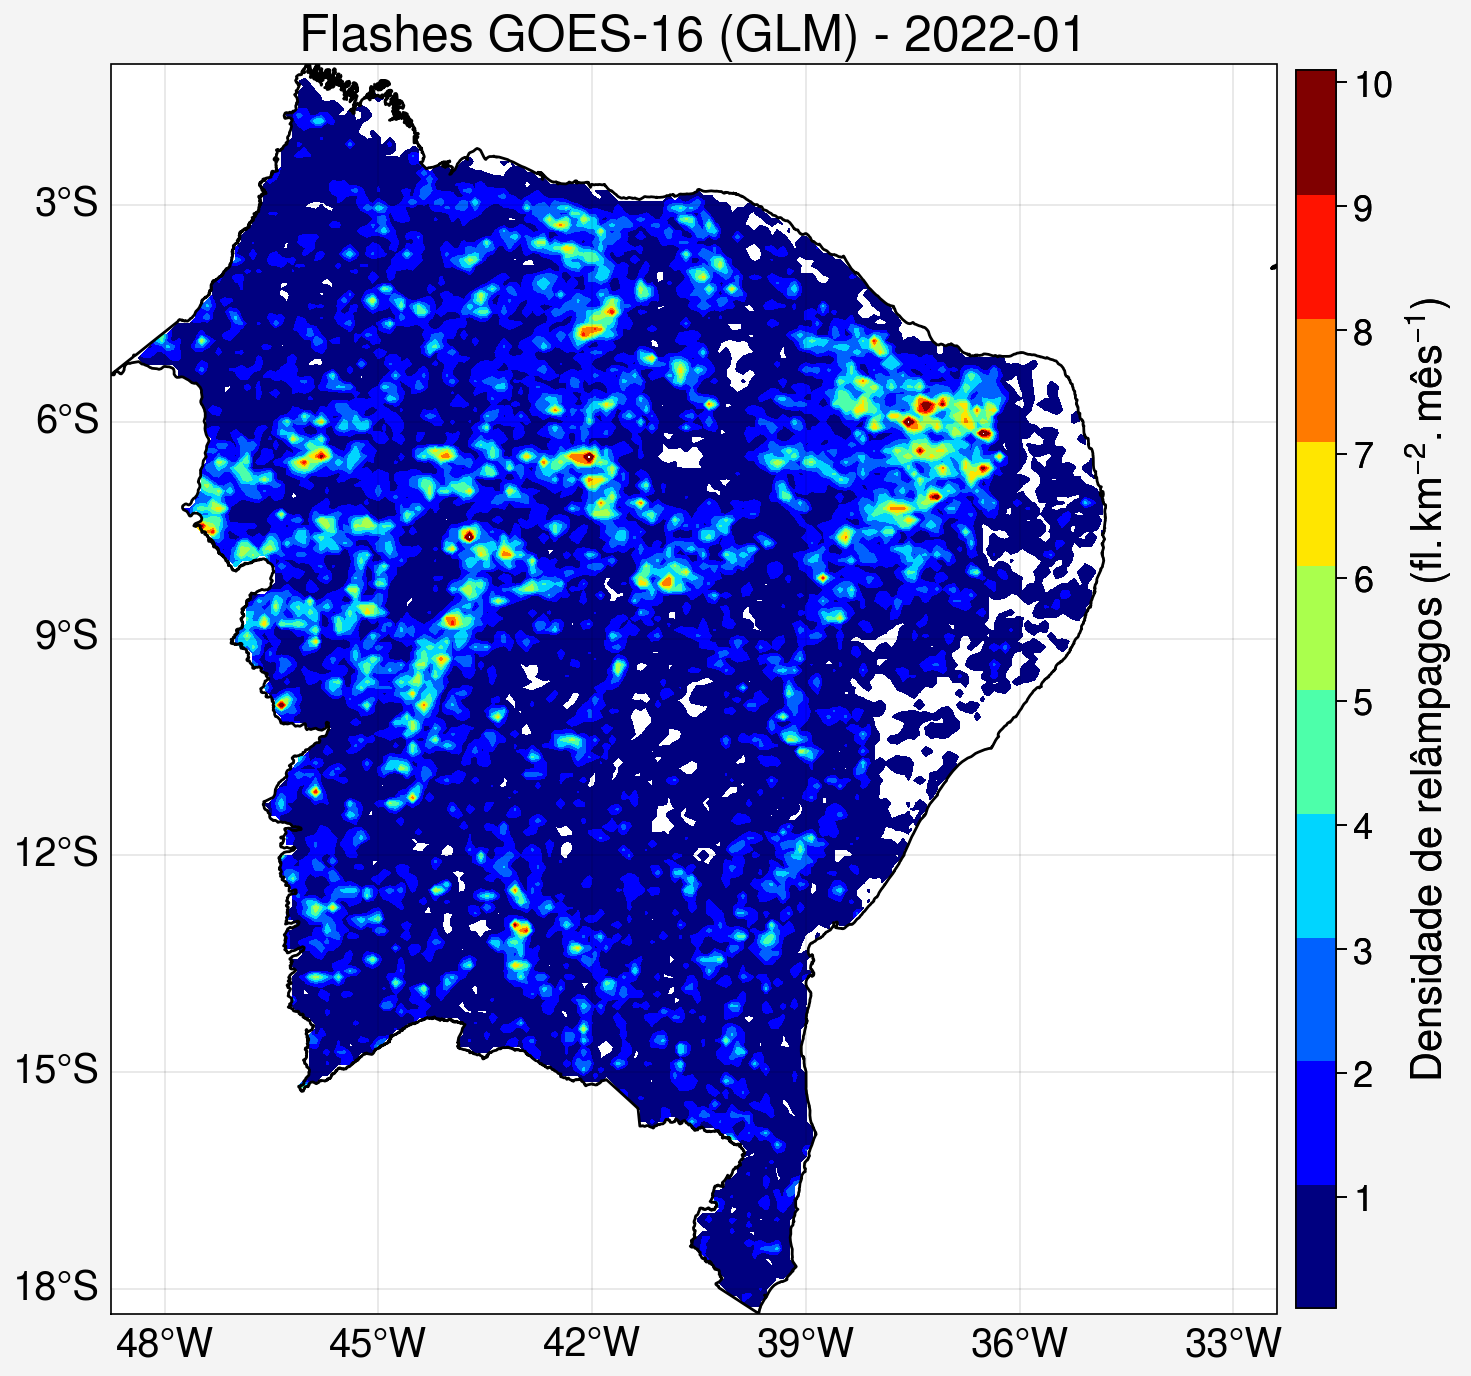

In [148]:
# limites da região
lonmin, lonmax, latmin, latmax = regiao_ibge['min_x'].min(), regiao_ibge['max_x'].max(), regiao_ibge['min_y'].min(), regiao_ibge['max_y'].max()

# fazendo o recorte do dado para o Estado
dsr = dsr.sel(lat=slice(latmin, latmax), lon=slice(lonmin, lonmax))

# define a moldura da figura
fig, ax = pplt.subplots(axwidth=6, tight=True, proj='pcarree')

# define formato da figura
ax.format(coast=False, borders=False, innerborders=False,
          labels=True,
          latlines=3, lonlines=3,
          latlim=(latmin, latmax),
          lonlim=(lonmin, lonmax),
          title=f'Flashes GOES-16 (GLM) - 2022-01',
          small='20px',
          large='25px')

# plota mapa
map1 = ax.contourf(dsr['lon'],
                   dsr['lat'],
                   dsr['flash'][0,:,:]/64.,
                   cmap='jet',
                   vmin=0.1, vmax=10,
                   levels=pplt.arange(0.1, 10., 1.0))

# plota contorno do Estado
regiao_ibge.plot(edgecolor='black', facecolor='none', linewidth=1, alpha=1, ax=ax)

# plota barra de cores da figura
fig.colorbar(map1, loc='r', label='Densidade de relâmpagos $(fl.km^{-2}.mês^{-1})$',
             ticks=1, ticklabelsize=13, labelsize=15,
             space=0.1, length=0.99, width=0.2)

# salva figura
fig.save('Fig4_salem_regiao.png', dpi=300)

## e) Plota `Município`

In [149]:
municipios_ibge = salem.read_shapefile('/content/BR_Municipios_2019.shp')
municipios_ibge

,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2,geometry,min_x,max_x,min_y,max_y
0,1100015,Alta Floresta D'Oeste,RO,7067.025,"POLYGON ((-62.22630 -11.89037, -62.20670 -11.8...",-62.894079,-61.886511,-13.118942,-11.827457
1,1100023,Ariquemes,RO,4426.571,"POLYGON ((-63.58751 -9.84984, -63.58715 -9.849...",-63.618222,-62.422617,-10.288282,-9.669160
2,1100031,Cabixi,RO,1314.352,"POLYGON ((-60.71834 -13.39058, -60.70904 -13.3...",-60.924764,-60.365289,-13.693700,-13.318590
3,1100049,Cacoal,RO,3792.892,"POLYGON ((-61.50114 -11.30119, -61.50104 -11.2...",-61.795798,-61.000595,-11.619209,-10.987534
4,1100056,Cerejeiras,RO,2783.300,"POLYGON ((-61.51346 -13.28575, -61.51534 -13.2...",-61.908043,-60.716651,-13.363706,-13.004330
...,...,...,...,...,...,...,...,...,...
5567,5222005,Vianópolis,GO,954.284,"POLYGON ((-48.53842 -16.75003, -48.54051 -16.7...",-48.598694,-48.255546,-17.129362,-16.627415
5568,5222054,Vicentinópolis,GO,737.255,"POLYGON ((-49.90713 -17.61460, -49.90588 -17.6...",-50.087037,-49.684173,-17.899038,-17.577277
5569,5222203,Vila Boa,GO,1060.172,"POLYGON ((-47.07742 -15.06330, -47.07747 -15.0...",-47.235067,-46.873698,-15.314679,-14.671943
5570,5222302,Vila Propício,GO,2181.583,"POLYGON ((-48.91463 -15.20939, -48.91462 -15.2...",-49.092276,-48.561829,-15.570494,-14.861683


In [150]:
# lendo shapefile
municipios_ibge = salem.read_shapefile('/content/BR_Municipios_2019.shp')

# selecionando o Estado de MG e SP
municipio_ibge = municipios_ibge.loc[municipios_ibge['NM_MUN'] == 'Altamira']

# leitura do aquivo netcdf
ds = xr.open_dataset(f'{dir}input/flash_goes16_mensal_2022-01.nc')

# aplica a mascara no dado Netcdf
dsr = ds.salem.roi(shape=municipio_ibge)

# tabelas dos estados selecionados
municipio_ibge

,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2,geometry,min_x,max_x,min_y,max_y
158,1500602,Altamira,PA,159533.328,"POLYGON ((-52.46076 -3.20911, -52.46091 -3.207...",-55.623871,-51.647538,-9.645178,-2.988717


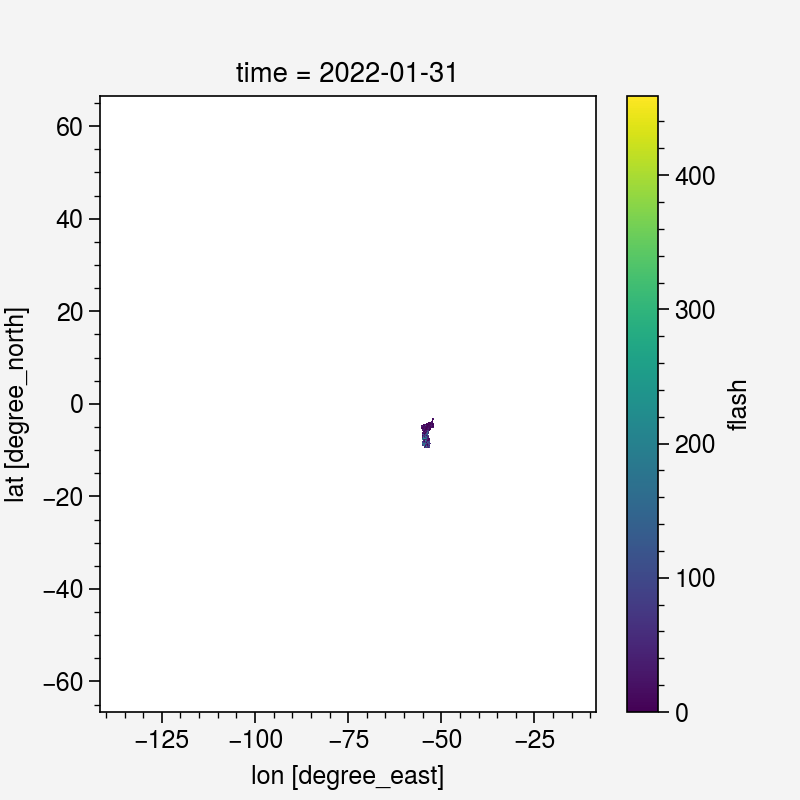

In [151]:
dsr['flash'].plot()

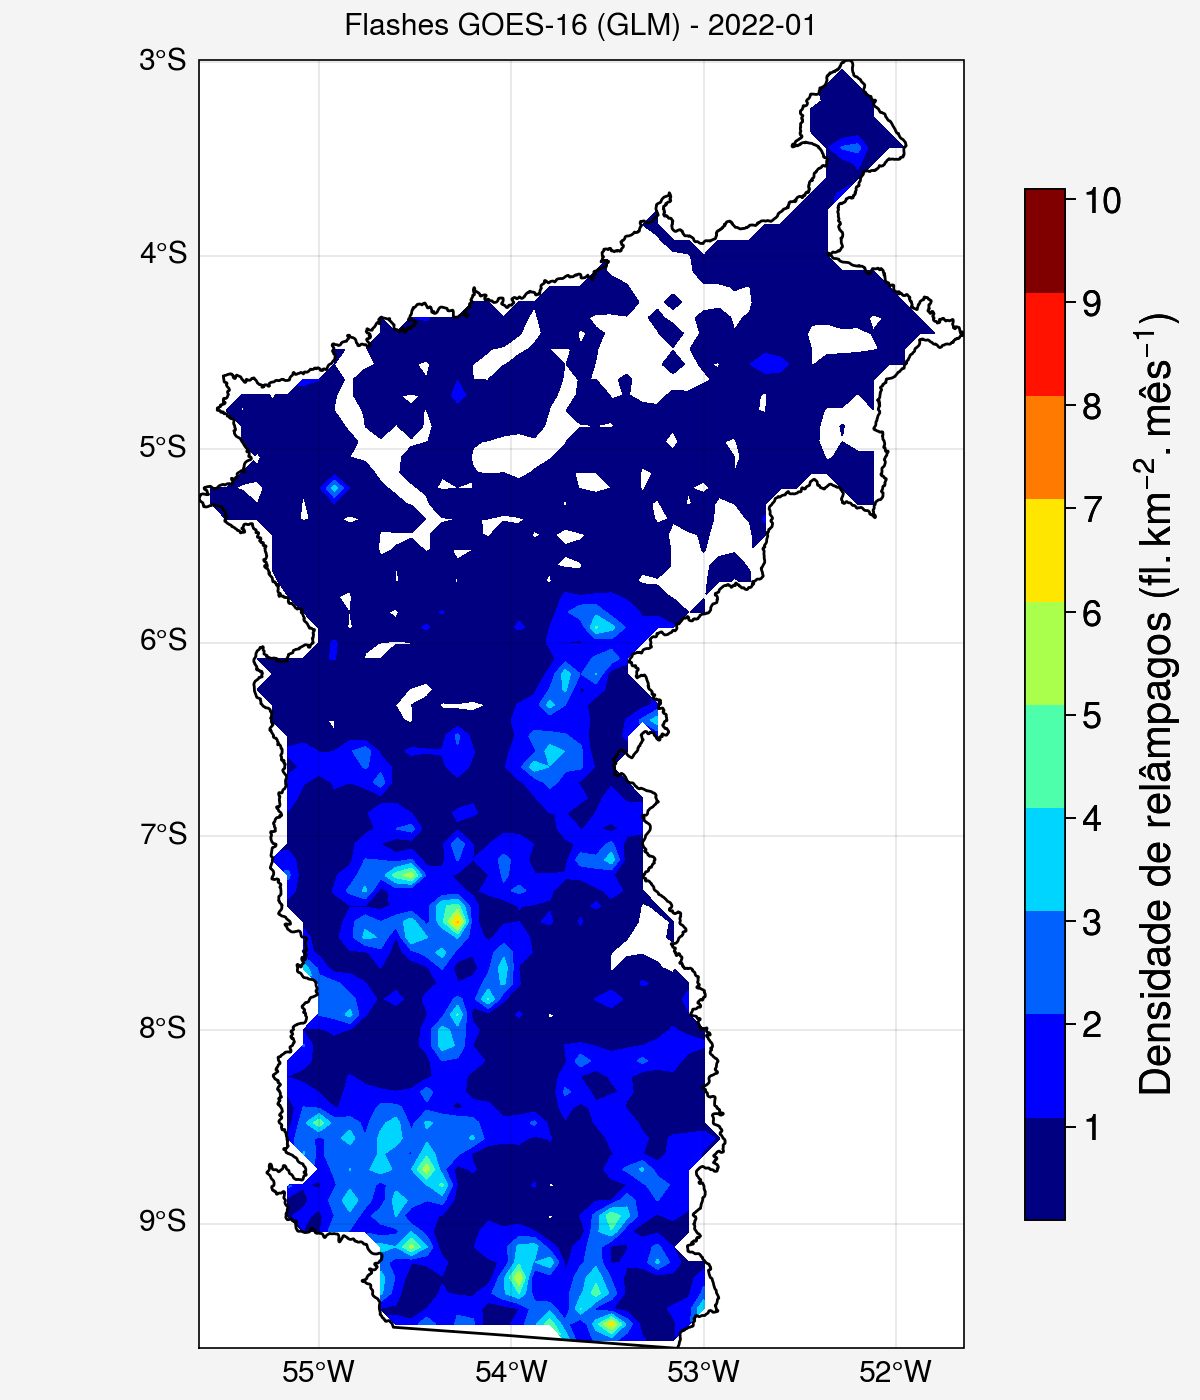

In [152]:
# limites da região
lonmin, lonmax, latmin, latmax = municipio_ibge['min_x'].min(), municipio_ibge['max_x'].max(), municipio_ibge['min_y'].min(), municipio_ibge['max_y'].max()

# define a moldura da figura
fig, ax = pplt.subplots(figsize=(6,7), tight=True, proj='pcarree')

# define formato da figura
ax.format(coast=False, borders=False, innerborders=False,
          labels=True,
          latlines=1, lonlines=1,
          latlim=(latmin, latmax),
          lonlim=(lonmin, lonmax),
          title=f'Flashes GOES-16 (GLM) - 2022-01',
          small='15px',
          large='15px')

# plota mapa
map1 = ax.contourf(dsr['lon'],
                   dsr['lat'],
                   dsr['flash'][0,:,:]/64.,
                   cmap='jet',
                   vmin=0.1, vmax=10,
                   levels=pplt.arange(0.1, 10., 1.0))

# plota shapefile
municipio_ibge.plot(edgecolor='black', facecolor='none', linewidth=1, alpha=1, ax=ax)

# plota barra de cores da figura
fig.colorbar(map1, loc='r', label='Densidade de relâmpagos $(fl.km^{-2}.mês^{-1})$',
             ticks=1, ticklabelsize=13, labelsize=15,
             length=0.80, width=0.2, space=-5.5)

# salva figura
fig.save('Fig5_salem_cidade.png', dpi=300)